[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/regression/polynomial_regression.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Polynomial Regression

This notebook shows an example of polynomial linear regression using Stochastic Gradient Descent.

We use a modification of the [Housing Prices Dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) stored in `data/housing.csv`. The dataset contains the following columns:
- price (dependent variable or target): Price of the house (in USD).
- width: Width of the house (in square feet).
- length: Length of the house (in square feet).
- bedrooms: Number of bedrooms.
- bathrooms: Number of bathrooms.
- stories: Number of stories.
- mainroad: Whether the house is near a main road (yes or no).
- guestroom: Whether the house has a guest room (yes or no).
- basement: Whether the house has a basement (yes or no).
- hotwaterheating: Whether the house has hot water heating (yes or no).
- airconditioning: Whether the house has air conditioning (yes or no).
- parking: Number of parking spots.
- prefarea: Whether the house is in a preferred area (yes or no).
- furnishingstatus: Furnishing status of the house (furnished, semi-furnished, unfurnished).
- quality: An integer value representing the quality of the house.

In [10]:
# make sure the required packages are installed
%pip install numpy pandas scikit-learn matplotlib seaborn --quiet

# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/regression'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone --depth 1 https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.

# import the required modules
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import pandas as pd
import numpy as np

import utils

pd.set_option('display.max_columns', None)  # Display all columns of a DataFrame in pandas
random_state = 42

Note: you may need to restart the kernel to use updated packages.


## Data preparation

We load the dataset from the file, split in train and test sets, and visualize the distribution of the variable values. Then, we handle outliers and missing values, and we transform the variable types to be able to use them in the model.

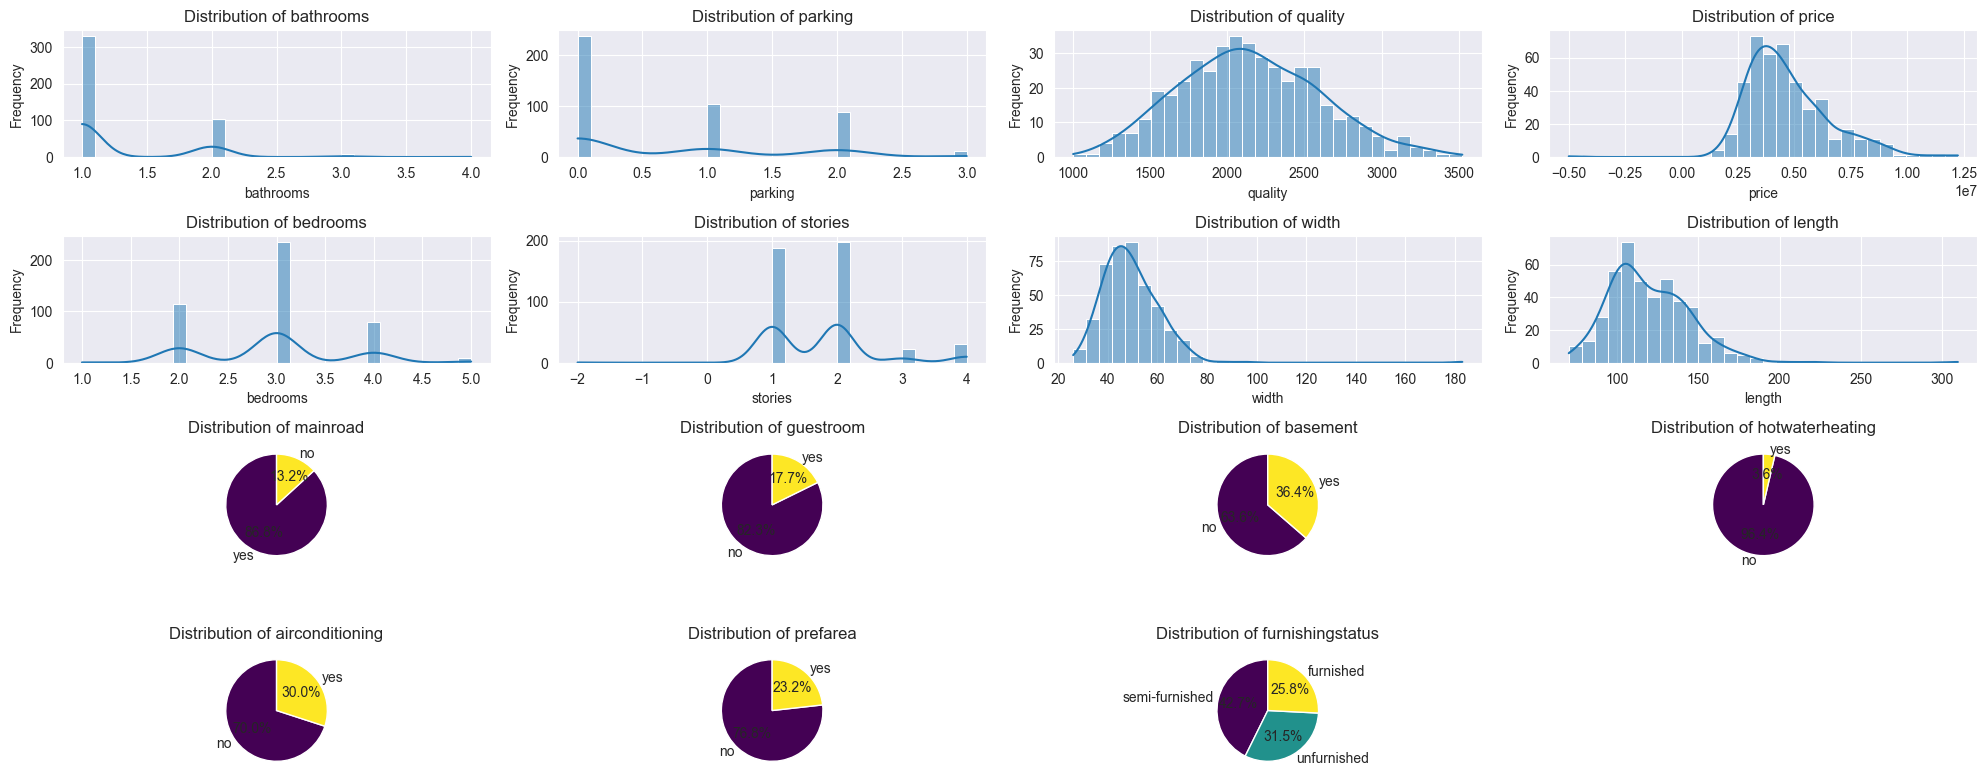

In [11]:
dataset_file_name = 'data/housing.csv'
integer_independent_vars = ['bedrooms', 'bathrooms', 'stories', 'parking', 'width', 'length', 'quality']
binary_independent_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
nominal_independent_vars = ['furnishingstatus']
independent_vars = integer_independent_vars + binary_independent_vars + nominal_independent_vars
dependent_var = 'price'

# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = utils.load_dataset_from_csv(dataset_file_name, independent_vars,
                                                                   dependent_var, 0.2, random_state)
# Concatenate X_train and y_train in train_dataset to visualize all the variables, including the target
train_dataset = pd.concat([X_train, y_train], axis=1)
# Visualize the distribution of the dataset
utils.plot_feature_value_distribution(train_dataset)

### Outliers

We detect the outliers in the numerical features using the IQR Tukey’s Fences rule. To apply Tukey's Fences, the variable should be numerical, symmetric and unimodal (one single peek value). In the visualization, we can see that `quality`, `price`, `bedrooms`, `width`, and `length` are the variables satisfying these conditions.

Then, we analyze the results and treat the outliers.

In [12]:
# Let's detect the outliers in the numerical features satisfying the Tukey's Fences conditions
tukeys_features = ['quality', 'price', 'bedrooms', 'width', 'length']
# outliers_df holds True for outlier and False for inlier
tukey_outliers_df = utils.detect_outliers_iqr(train_dataset[tukeys_features], threshold=3.0)
# We take the train dataset, filter the tukey's features apply the outliers_df mask to get the outliers
# If True (outlier), the outliers variable holds the outlier value; otherwise, it holds NaN 
tukey_outliers = train_dataset[tukeys_features][tukey_outliers_df]  \
    .dropna(how='all')  # Drop rows with all NaN values (no outlier in the row)
print("Values of the outliers in the training set:\n", tukey_outliers, end='\n\n')

Values of the outliers in the training set:
      quality       price  bedrooms  width  length
550      NaN  -5000000.0       NaN    NaN     NaN
3        NaN  12215000.0       NaN    NaN     NaN
7        NaN         NaN       NaN  183.0   310.0
1        NaN  12250000.0       NaN    NaN     NaN


The numeric variables `bathrooms`, `parking`, and `stories` do meet the requirements of the Tukey's Fences rule. Thus, we apply the MAD (Median Absolute Deviation) outlier detection method to them. This method can be applied to asymmetric and multimodal data. Median Absolute Deviation (MAD) is defined as $MAD = median(|X - median(X)|)$. An outlier is a value that is more than `threshold` times the MAD away from the median. The threshold commonly set to 3.0.

In [13]:
mad_features = ['bathrooms', 'parking', 'stories']
# outliers_df holds True for outlier and False for inlier
mad_outliers_df = utils.detect_outliers_mad(train_dataset[mad_features], threshold=3.0)
# We take the train dataset, filter the mad features apply the mad_outliers_df mask to get the outliers
# If True (outlier), the outliers variable holds the outlier value; otherwise, it holds NaN 
mad_outliers = train_dataset[mad_features][mad_outliers_df]  \
    .dropna(how='all')  # Drop rows with all NaN values (no outlier in the row)
print("Values of the outliers in the training set using the MAD method:\n", mad_outliers, end='\n\n')

Values of the outliers in the training set using the MAD method:
      bathrooms  parking  stories
344        NaN      NaN     -2.0


This is a summary of the outliers found with the Tukey's Fences rule:
- The `width` and `length` of one sample are outliers. It does not seem to be erroneous data, so we can scale their values to lessen the impact of their values ([`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) is less sensitive to outliers than `StandardScaler` because it uses the median and IQR instead of mean and standard deviation). If data is normal with no outliers, `StandardScaler` is a better choice.
- The `stories` variable has one outlier. It is a negative value that is an error. That is the only erroneous value for that sample/individual, so we set it to NaN to impute it later (instead of removing the whole sample).
- The `price` value has three outliers:
  1. Two big values that make sense (very expensive houses). We can keep it with no scaling because it is the target variable.
  2. One negative value that is an error. In this case, we must remove the whole sample because `price` is the target variable to predict (imputation it does not make sense). 

In [14]:
# Set the negative values to NaN in the `stories` column
utils.modify_cells_lower_than(X_train, column_names=['stories'], cell_value=np.nan, threshold=0)
utils.modify_cells_lower_than(X_test, column_names=['stories'], cell_value=np.nan, threshold=0)
print("Number of values with stories < 0 in the training set:", X_train['stories'][X_train['stories'] < 0].count())
# Remove the samples with negative values for the target variable (`price`) from both train and test datasets 
y_train, X_train = utils.drop_rows_lower_than(y_train, X_train, threshold=0)
y_test, X_test = utils.drop_rows_lower_than(y_test, X_test, threshold=0)
print("Number of values with price < 0 in the training set:", y_train[y_train < 0].count())
print("Number of values with price < 0 in the test set:", y_test[y_test < 0].count())

Number of values with stories < 0 in the training set: 0
Number of values with price < 0 in the training set: 0
Number of values with price < 0 in the test set: 0


### Missing values

First, we detect the missing values in the dataset. Then, we analyze the results and treat the missing values.

In [15]:
# We print the instances that have any missing values
utils.show_missing_values(X_train, 'train')
utils.show_missing_values(X_test, 'test')

Missing values in the train dataset:
      bedrooms  bathrooms  stories  parking  width  length  quality mainroad  \
56        4.0          2      2.0        1   62.0   143.0     3026      NaN   
57        4.0          2      4.0        2   60.0   138.0     2679      yes   
59        3.0          1      NaN        1    NaN   133.0     2498      yes   
344       4.0          2      NaN        0   40.0    96.0     2371      yes   
58        3.0          1      1.0        1    NaN     NaN     2841      yes   

    guestroom basement hotwaterheating airconditioning prefarea  \
56         no       no              no             yes      yes   
57         no       no              no              no       no   
59         no       no             NaN             yes      NaN   
344        no       no              no              no       no   
58         no      yes              no             yes      yes   

    furnishingstatus  
56    semi-furnished  
57               NaN  
59             

There are missing values in the dataset. We will treat them using the same criteria in train and test sets. First, if there are 3 or more missing values in a sample, we will remove the whole sample.  **Important**: We should remove the corresponding rows in the target variable as well.

In [16]:
X_train, y_train = utils.drop_rows_multiple_missing_values(X_train, y_train, threshold=3)
X_test, y_test = utils.drop_rows_multiple_missing_values(X_test, y_test, threshold=3)

For the rest of the missing values, we will impute the missing values using simple univariate imputation methods: 
- For the integer variables, we will use the median value (mean would produce double values and it is more sensitive to outliers).
- For the binary and nominal variables, we will use the most frequent value (mode).

Let's start by replacing the missing values in the dataset with the median value of the column.

In [17]:
integer_imputer = SimpleImputer(strategy='median')
X_train[integer_independent_vars] = integer_imputer.fit_transform(X_train[integer_independent_vars])
X_test[integer_independent_vars] = integer_imputer.transform(X_test[integer_independent_vars])

Now, for the binary and nominal variables, we will use the most frequent value (mode).

In [18]:
binary_nominal_imputer = SimpleImputer(strategy='most_frequent')
binary_nominal_features = binary_independent_vars + nominal_independent_vars
X_train[binary_nominal_features] = binary_nominal_imputer.fit_transform(X_train[binary_nominal_features])
X_test[binary_nominal_features] = binary_nominal_imputer.transform(X_test[binary_nominal_features])
# Now, there are no missing values in the dataset
print("Missing values in the training and test sets after handling missing values.")
utils.show_missing_values(X_train, 'train')
utils.show_missing_values(X_test, 'test')

Missing values in the training and test sets after handling missing values.
Missing values in the train dataset:
 Empty DataFrame
Columns: [bedrooms, bathrooms, stories, parking, width, length, quality, mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus]
Index: []

Missing values in the test dataset:
 Empty DataFrame
Columns: [bedrooms, bathrooms, stories, parking, width, length, quality, mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus]
Index: []


### Set the valid types for the variables

Nominal variables should be converted into numbers so that the model can understand them. First, we deal with binary variables, changing "yes" and "no" values to 1 and 0, respectively.

In [19]:
for feature_name in binary_independent_vars:
    X_train[feature_name] = X_train[feature_name].map({'yes': 1, 'no': 0})
    X_test[feature_name] = X_test[feature_name].map({'yes': 1, 'no': 0})

`furnishingstatus` cannot be converted into an ordinal integer value (label encoding) because it represents no order. Therefore, we use one-hot encoding to transform it into a format that the model can understand.

In [20]:
for feature_name in nominal_independent_vars:
    X_train = (pd.get_dummies(X_train, columns=[feature_name])
               .astype(int))  # sets it to 0 or 1 instead of True or False
    X_test = pd.get_dummies(X_test, columns=[feature_name]).astype(int)

We have finished the data preparation. We finally visualize the influence of the features on the target variable and store the curated dataset in a single csv file.

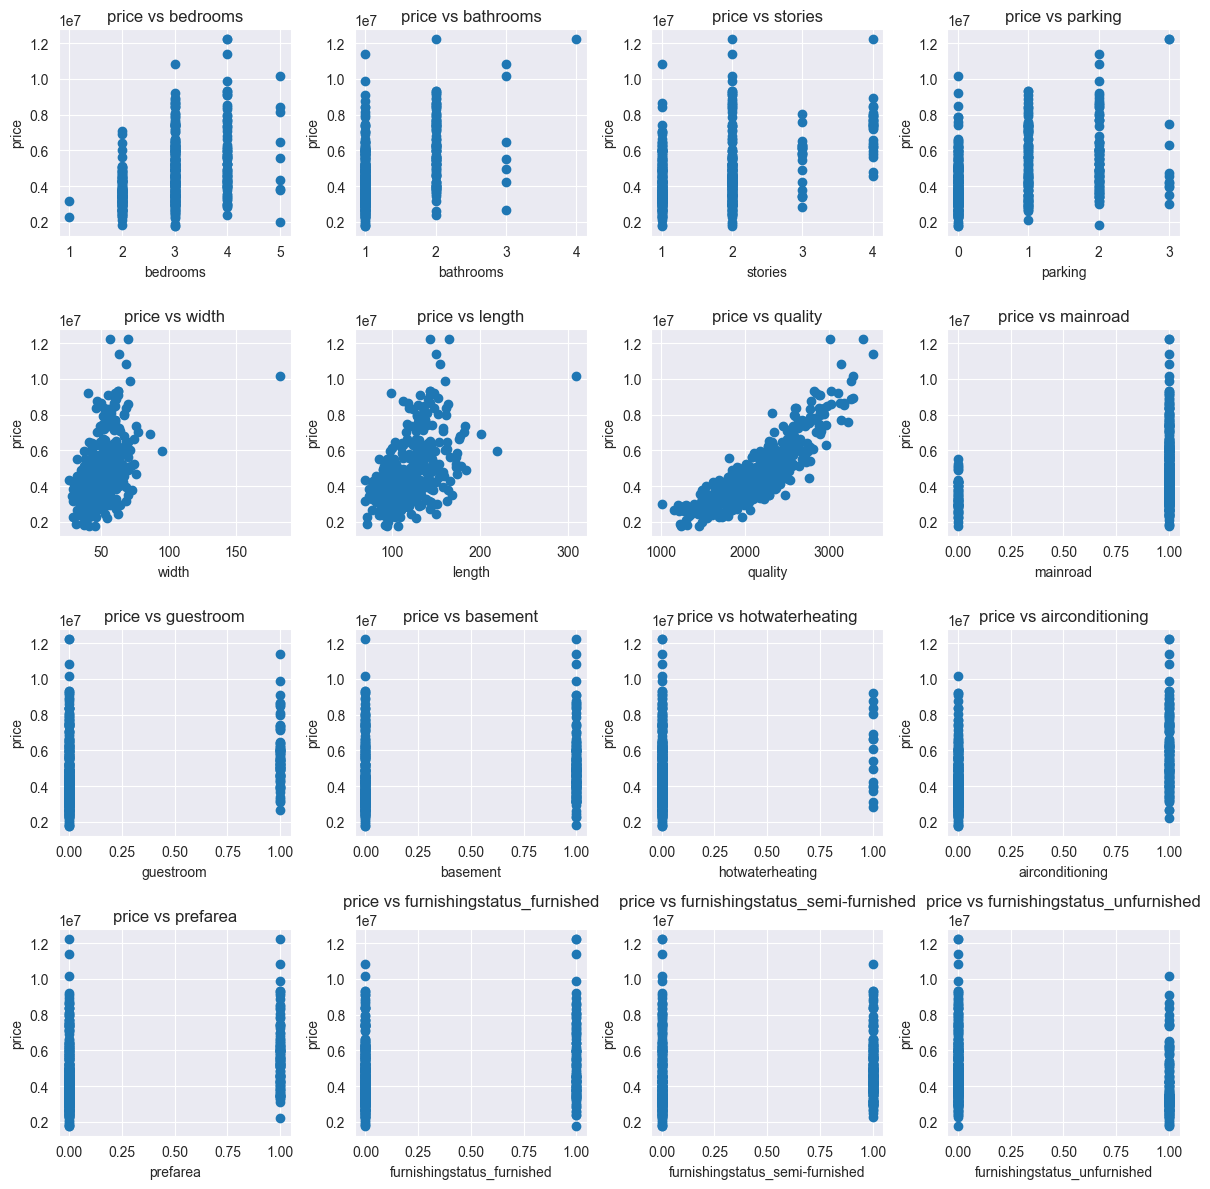

In [21]:
# Visualize the influence of the features on the target variable
utils.visualize_influence(X_train, y_train)
# Store the curated X_train, X_test, y_train and y_text merged in a single csv file
utils.store_dataset(X_train, y_train, X_test, y_test, 'data/housing_curated.csv')

## Model creation, training, and evaluation

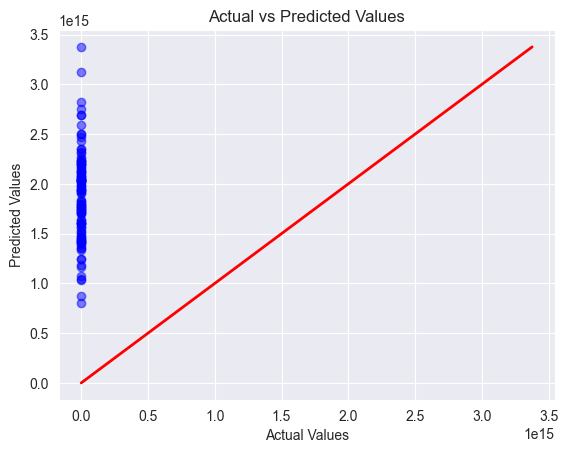

Mean Squared Error (MSE): 3720238582304172263622779600896.0000
Root Mean Squared Error (RMSE): 1928792000788102.7500
Mean Absolute Error (MAE): 1876056298110430.2500
R-squared determination coefficient: -796696766187375488.0000


In [22]:
metrics= utils.create_SDG_regression_model_and_evaluate(X_train, y_train, X_test, y_test, random_state)
utils.show_regression_performance(*metrics)

## ✨ Activity 1 ✨

The previous model does not perform well. After reading all the previous code, there is something we should have done, and we have not done. Can you identify what it is? Do it and check if the model has increased its performance. 

In [23]:
# Write your code here.

 

## ✨ Activity 2 ✨

Does it occur to you to perform any *feature engineering* to improve the model? Do one step after another and check if the model has increased its performance.

In [24]:
# Write your code here.

 